#Data load

In [3]:
!pip install darts --q

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from darts import TimeSeries
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from darts.utils.statistics import check_seasonality
from darts.models import NaiveSeasonal, NaiveDrift
from darts import metrics
from darts.models import XGBModel
from darts.models import ExponentialSmoothing
from darts.models import Prophet
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error
import plotly.graph_objects as go
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display, clear_output
from IPython.display import display

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/Machine Learning/Data/time_series.csv")

# Exploratory Data Analysis

In [8]:
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [9]:
# Range of dates
df.date.min(), df.date.max()

('2013-01-01', '2017-12-31')

In [10]:
# Number of unique stores and items
df.store.nunique(), df.item.nunique()

(10, 50)

In [11]:
# Make date an index
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.head(10)

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
2013-01-06,1,1,12
2013-01-07,1,1,10
2013-01-08,1,1,9
2013-01-09,1,1,12


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   store   913000 non-null  int64
 1   item    913000 non-null  int64
 2   sales   913000 non-null  int64
dtypes: int64(3)
memory usage: 27.9 MB


Let's change the datatypes to save some memory:

In [13]:
df.sales.max()

231

In [14]:
df[df.columns] = df[df.columns].astype('uint8')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   store   913000 non-null  uint8
 1   item    913000 non-null  uint8
 2   sales   913000 non-null  uint8
dtypes: uint8(3)
memory usage: 9.6 MB


Let's build a plot visualizing data sales for each of the 50 items across all the stores:

In [36]:
# Calculate average, min, and max sales for each item over time
summary = df.groupby(['date', 'item']).agg(
    avg_sales=('sales', 'mean'),
    min_sales=('sales', 'min'),
    max_sales=('sales', 'max')
).reset_index()

output = widgets.Output()

# Function to create an interactive plot for a selected item
def create_interactive_plot(item):
    item_data = summary[summary['item'] == item]

    fig = go.Figure()

    # Add the average sales line
    fig.add_trace(go.Scatter(
        x=item_data['date'],
        y=item_data['avg_sales'],
        mode='lines',
        name='Average Sales'
    ))

    # Add the range (min to max sales)
    fig.add_trace(go.Scatter(
        x=item_data['date'].tolist() + item_data['date'].tolist()[::-1],
        y=item_data['max_sales'].tolist() + item_data['min_sales'].tolist()[::-1],
        fill='toself',
        fillcolor='rgba(173,216,230,0.3)',
        line_color='rgba(255,255,255,0)',
        showlegend=True,
        name='Sales Range'
    ))

    fig.update_layout(
        title=f'Sales Dynamics for item {item}',
        xaxis_title='Date',
        yaxis_title='Sales',
        template='plotly_white'
    )

    fig.show()

# Dropdown widget for item selection
item_dropdown = widgets.Dropdown(
    options=summary['item'].unique(),
    description='Select Item:',
    style={'description_width': 'initial'}
)

# Update function to refresh the plot based on selected item
def update_plot(change):
    clear_output(wait=True)
    create_interactive_plot(change['new'])
    display(item_dropdown)

# Link the dropdown selection to the update function
item_dropdown.observe(update_plot, names='value')

# Initialize with the first item selected
create_interactive_plot(summary['item'].unique()[0])

# Display the dropdown widget
display(item_dropdown)

Dropdown(description='Select Item:', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 1…

(static image as an example for viewing in github):

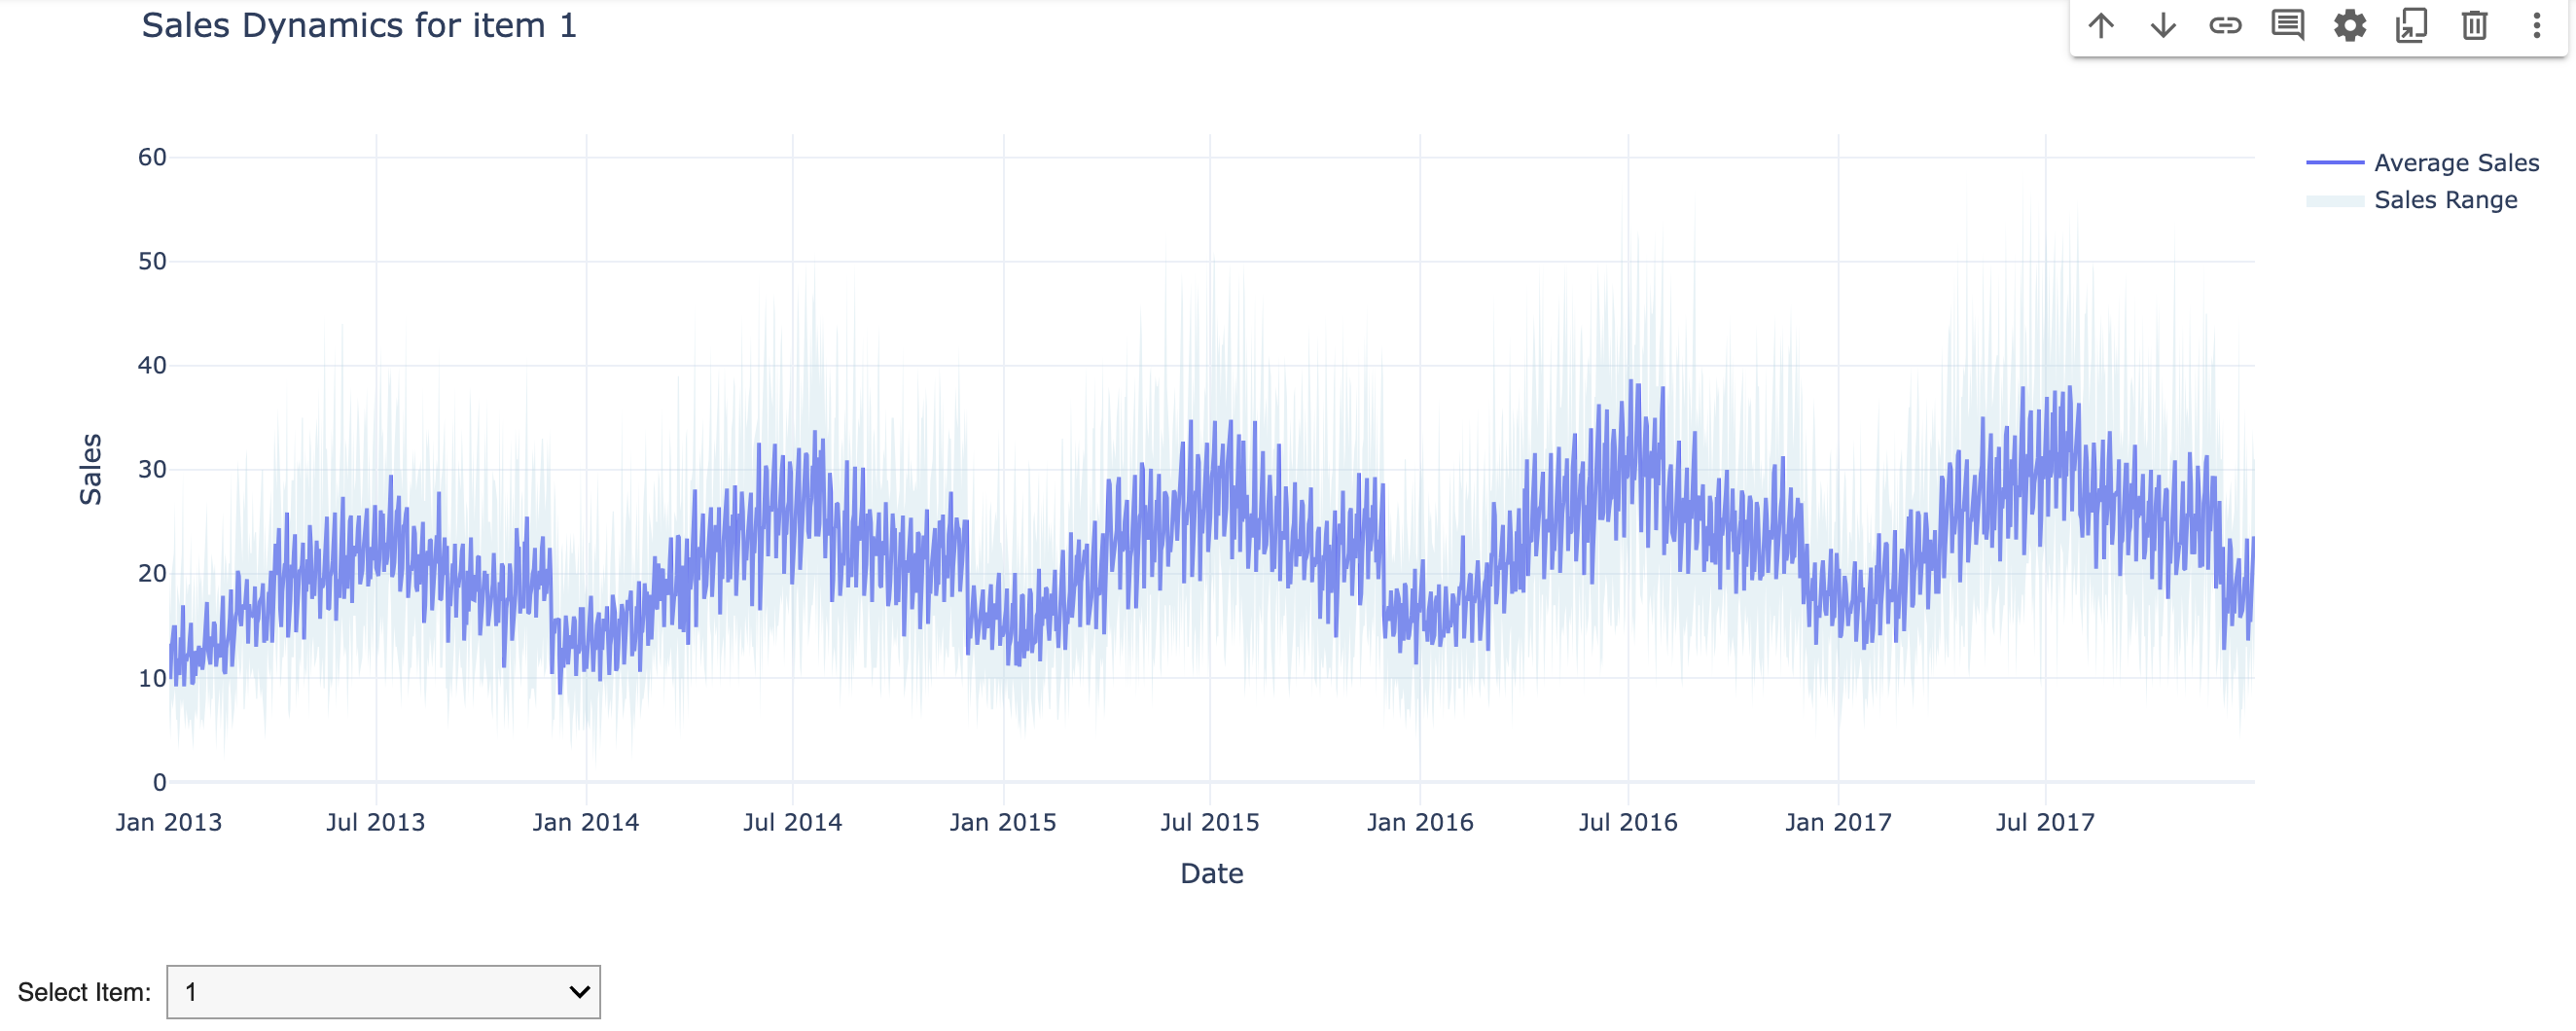

**Observation:**

There is a seasonal trend in the sales data. Sales increase and decrease over the course of an annual cycle. Peaks and troughs are visible, indicating periods of high and low sales.

There is a general trend of average sales increasing over time.

The area representing the range of sales (from minimum to maximum) shows significant variation around the average sales line. This variation also appears to increase during periods of high sales.

The graphs also show spikes in sales that may be associated with certain events, holidays, or promotions.

Let's focus on the data for 1 random item from 1 random store for now:

In [16]:
df_12_1 = df[(df.item==12) & (df.store==1)]
df_12_1.head(5)

,store,item,sales
date,,,
2013-01-01,1,12,33
2013-01-02,1,12,35
2013-01-03,1,12,41
2013-01-04,1,12,45
2013-01-05,1,12,46


Let's decompose the data into trend and seasonality using statsmodels library:

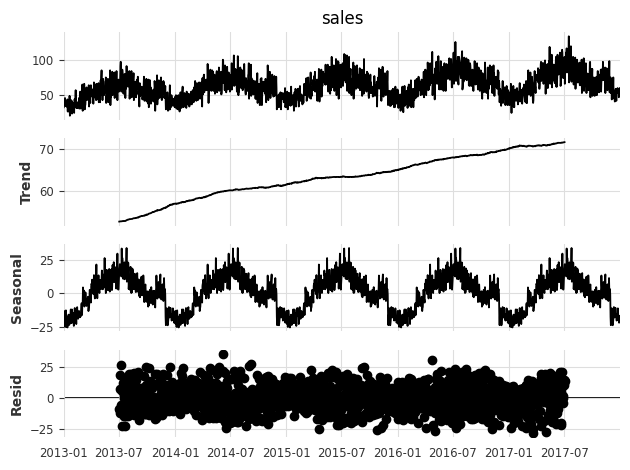

In [15]:
decomposition_plot_multi = seasonal_decompose(df_12_1.sales, period=365, model='additive')
decomposition_plot_multi.plot()
plt.show()

From this decomposition, we see a clear pattern of seasonality and an upward trend; the residuals have no pattern and are centered around 0, but have quite a lot of variability.

**Autocorrelation Function (ACF)**

The ACF measures the correlation between the time series and its lagged values, or past observations. For example, a lag of 1 means comparing each value with the one immediately preceding it, while a lag of 2 compares each value with the observation two steps before, and so on. The ACF plot displays correlations for a range of lags, helping us see whether the time series shows dependencies at different points in time.

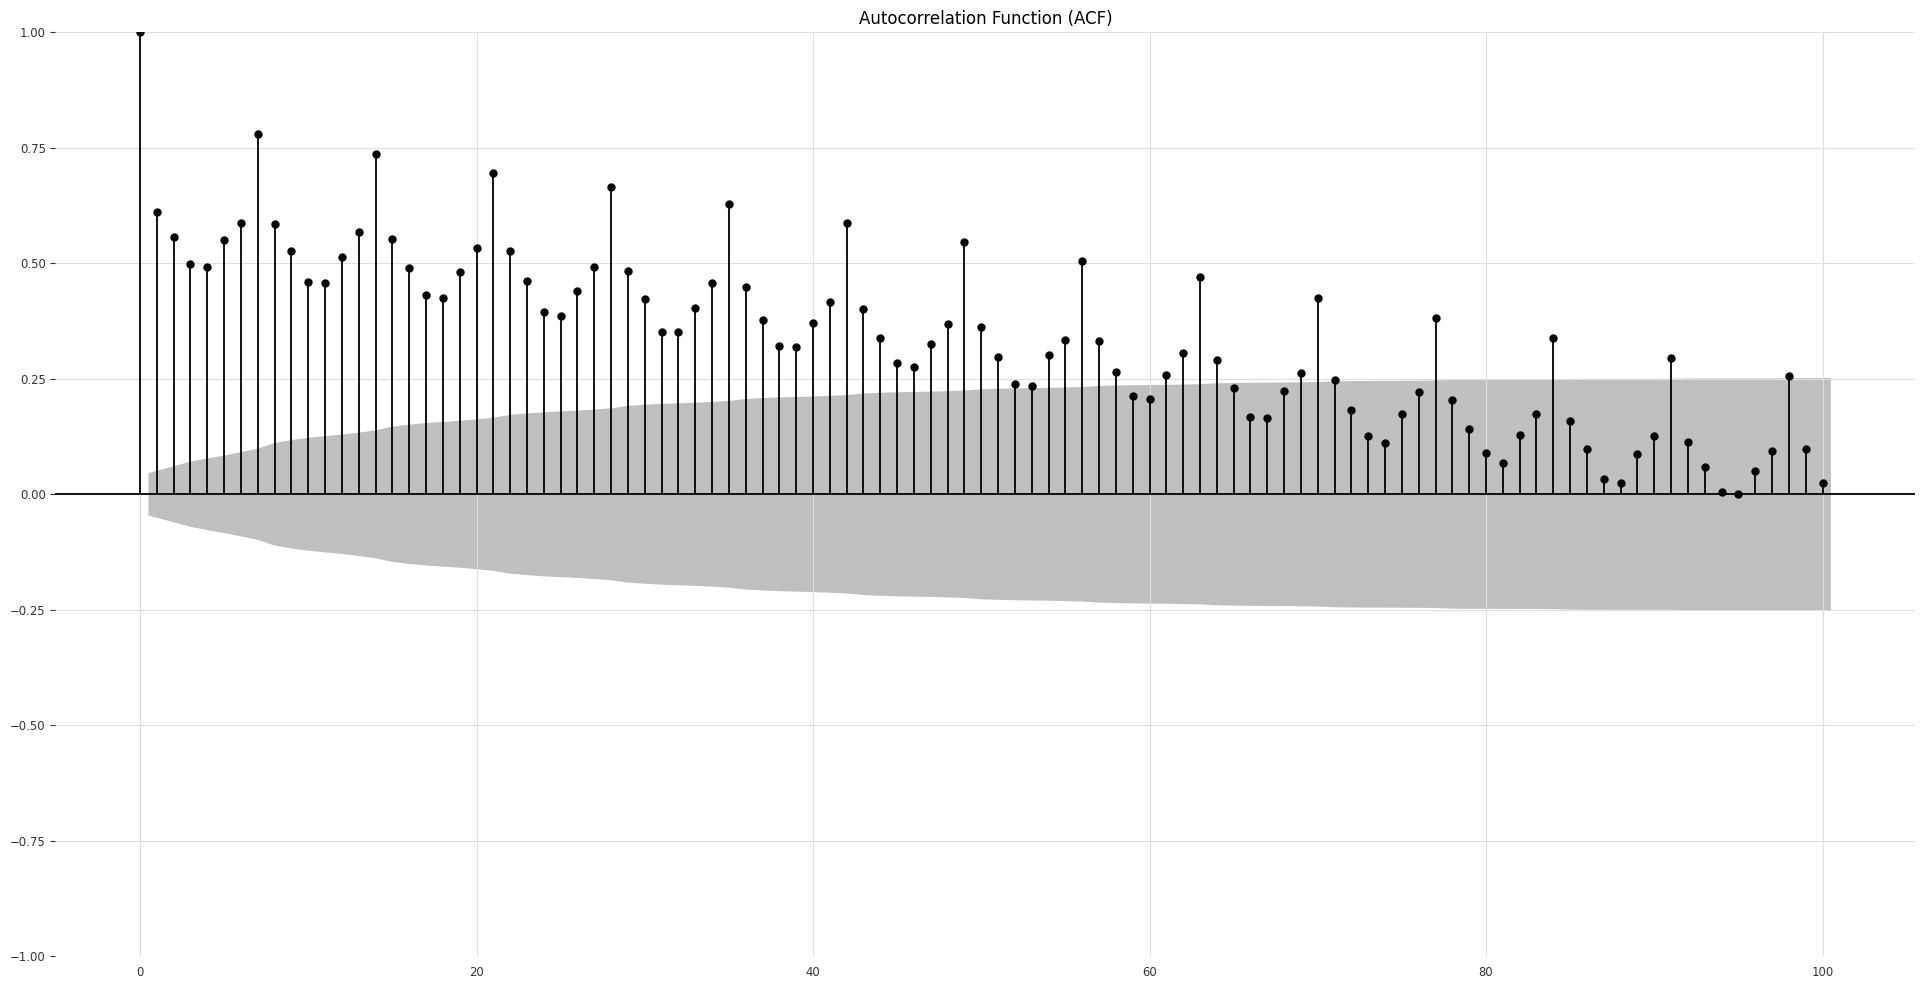

In [27]:
fig, ax = plt.subplots(figsize=(24, 12))
plot_acf(df_12_1.sales, lags=100, ax=ax)
plt.title('Autocorrelation Function (ACF)')

plt.show();

**Observations:**

There are noticeable peaks at regular intervals (e.g., at lags 7, 14, 21, etc.), indicating weekly seasonality in the data. This suggests that the sales pattern repeats itself every week.

The autocorrelation values ​​gradually decrease with increasing lag, but the fact that they remain statistically significant even at large lags (up to almost 60) indicates that past values ​​continue to have some influence over a fairly long period, although it diminishes over time.

**Partial Autocorrelation Function (PACF)**

The PACF plot measures the correlation between the time series and its lagged values, controlling for the values of intermediate lags. For instance, the PACF at lag 2 shows the correlation between observations separated by two steps, removing the influence of the intermediate lag (lag 1). This "partial" correlation provides a clearer view of the direct relationship at each lag.

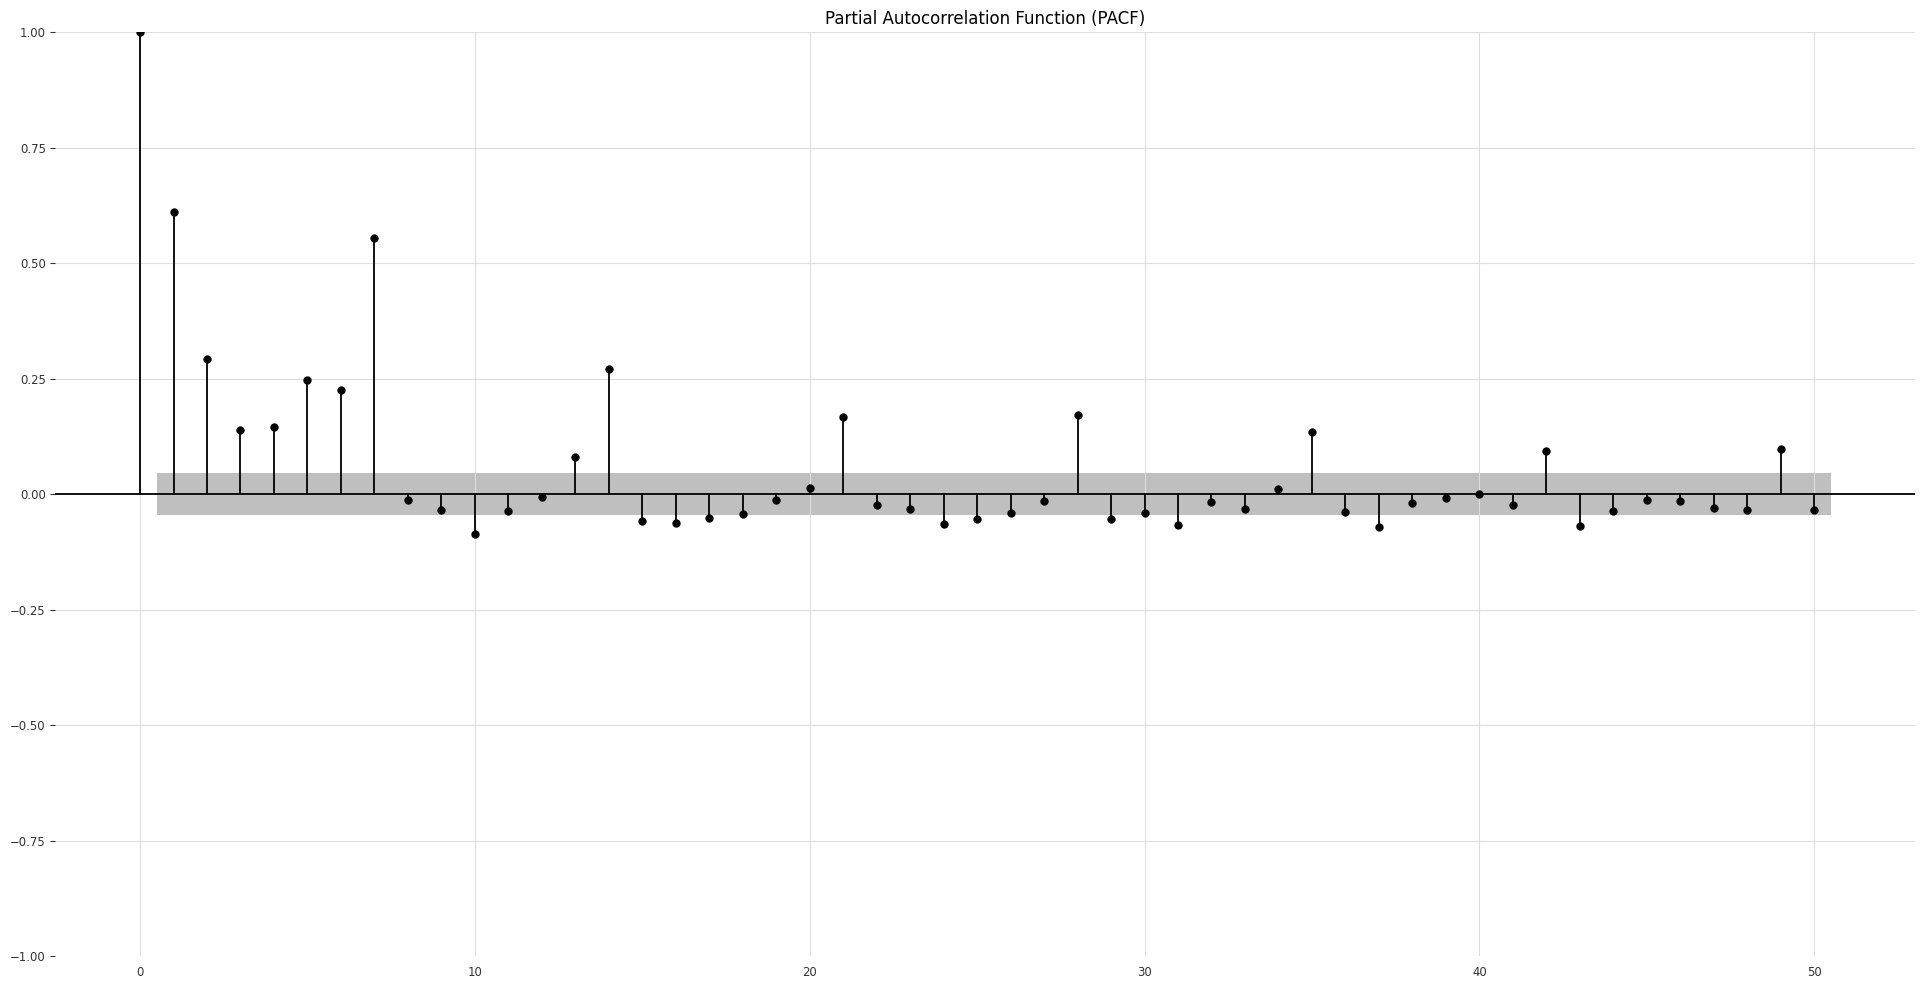

In [28]:
fig, ax = plt.subplots(figsize=(24, 12))
plot_pacf(df_12_1.sales, lags=50, method='ywm', ax=ax)
plt.title('Partial Autocorrelation Function (PACF)')

plt.show()

Large values ​​at lags 7, 14, 21, etc. in the PACF plot confirm that the correlation at these lags remains significant even after removing the influence of intermediate lags.



Let's check for seasonality using functionality of darts library:

In [17]:
series = TimeSeries.from_dataframe(df_12_1, value_cols='sales')

In [16]:
for m in range(2, 100):
    is_seasonal, period = check_seasonality(series, m=m, alpha=0.05, max_lag=100)
    if is_seasonal:
        print("There is seasonality of order", period)

There is seasonality of order 7
There is seasonality of order 14
There is seasonality of order 21
There is seasonality of order 28
There is seasonality of order 35
There is seasonality of order 42
There is seasonality of order 49
There is seasonality of order 56
There is seasonality of order 63
There is seasonality of order 70
There is seasonality of order 77
There is seasonality of order 84
There is seasonality of order 91
There is seasonality of order 98


#Models

Let's split the data into training and validation sets with data from years 2013-2016 going into train set and data from 2017 going into validation set:

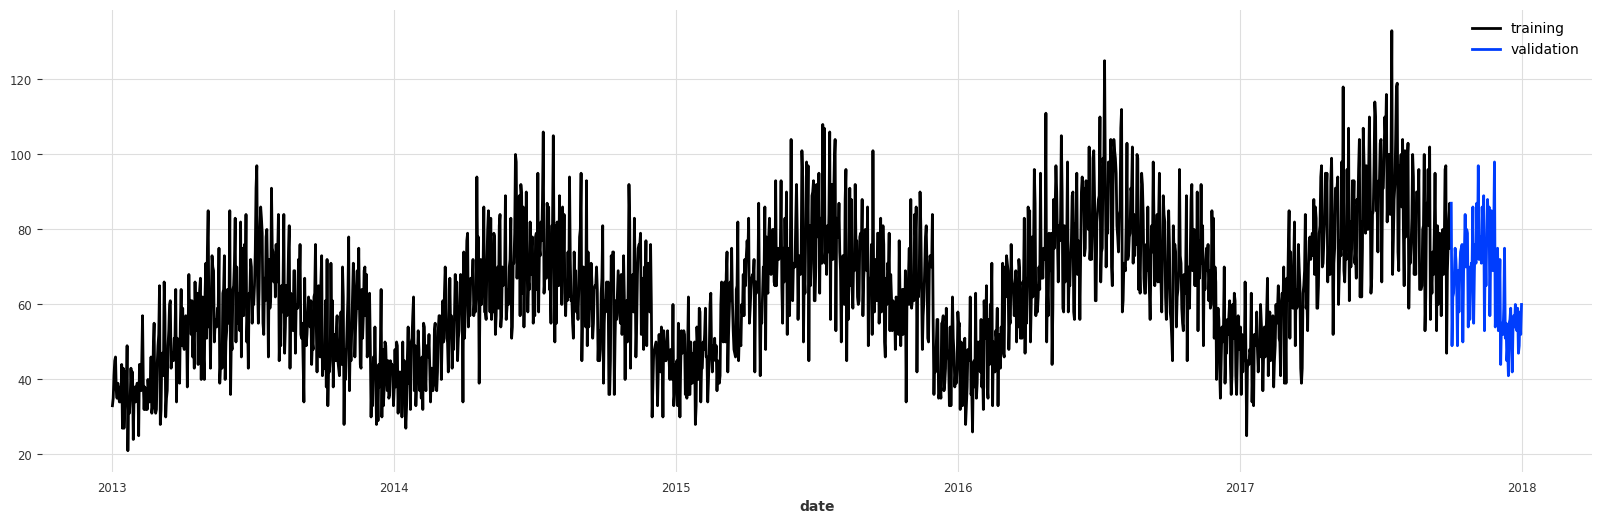

In [18]:
split_date = pd.Timestamp("2017-10-01")
train, val = series.split_before(split_date)

plt.figure(figsize=(20,6))
train.plot(label="training")
val.plot(label="validation")

plt.show()

Let's define functions for plotting and evaluating predictions for later use. We'll use Mean Absolute Percentage Error metric for evaluation.

In [19]:
def plot_forecast(actual, forecast):
  plt.figure(figsize=(20,6))

  actual.plot(label='Actual')
  forecast.plot(label='Forecast')

  plt.legend()
  plt.show()

In [20]:
def calculate_mape(actual, forecast):
  m = metrics.mape(actual, forecast)
  print(f"MAPE: {m:.2f}%")

## Naive Model

In [20]:
# Naive Seasonal
naive_model = NaiveSeasonal(K=364)
naive_model.fit(train)
naive_forecast = naive_model.predict(len(val))

# Naive Drift
drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(len(val))

# Naive Combined
combined_forecast = drift_forecast + naive_forecast - train.last_value()

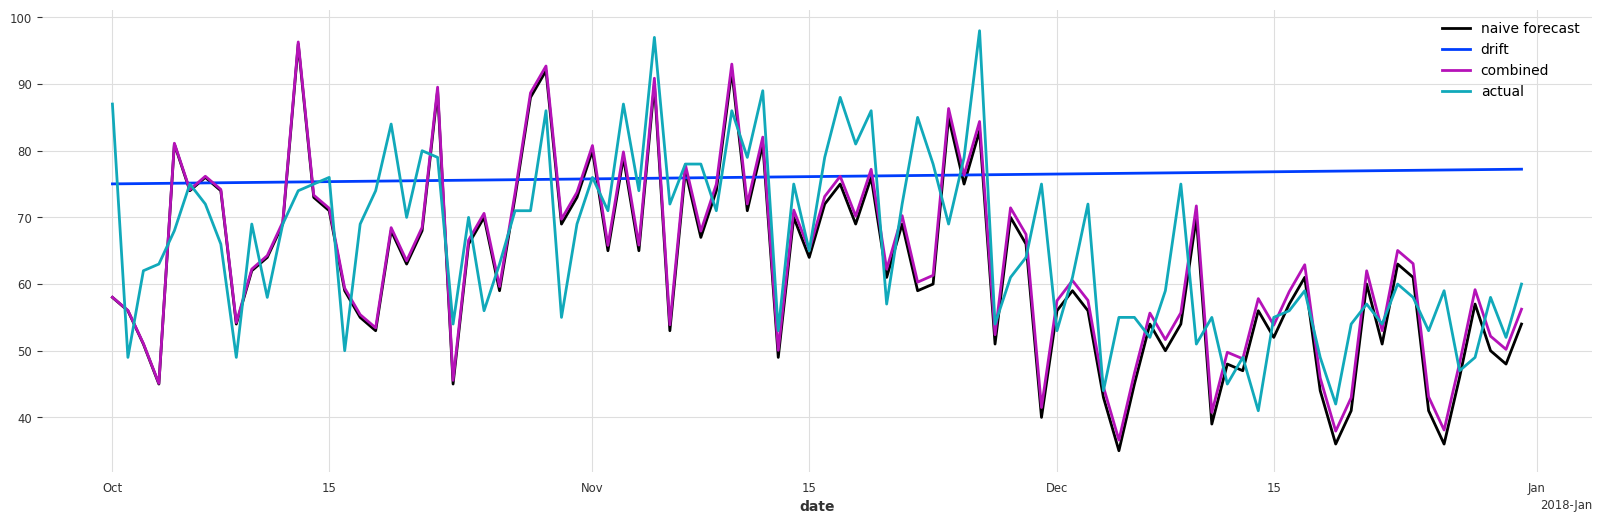

MAPE: 13.07%


In [21]:
plt.figure(figsize=(20,6))

naive_forecast.plot(label="naive forecast")
drift_forecast.plot(label="drift")
combined_forecast.plot(label="combined")
val.plot(label="actual")

plt.show()

calculate_mape(val, combined_forecast)

## XGB

In [21]:
# Enrich the dataset with date features
def enrich_with_date_features(df):
    df = df.copy()
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofweek'] = df.index.dayofweek
    df['dayofyear'] = df.index.dayofyear
    df['quarter'] = df.index.quarter
    df['weekofyear'] = df.index.isocalendar().week
    return df

df_12_1 = enrich_with_date_features(df_12_1)

In [23]:
# Create TimeSeries object for covariates
covariates = TimeSeries.from_dataframe(df_12_1, value_cols=['day', 'month', 'year', 'dayofweek', 'dayofyear', 'quarter', 'weekofyear'])

# Split covariates into train and validation sets
cov_train, cov_val = covariates.split_before(split_date - pd.to_timedelta(1, unit='d'))

In [ ]:
xgb = XGBModel(
    lags=[-1, -7, -364],
    lags_past_covariates=[-1],
    output_chunk_length=30,
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8
)

xgb.fit(series=train, past_covariates=cov_train)

forecast = xgb.predict(len(val), past_covariates=cov_val)

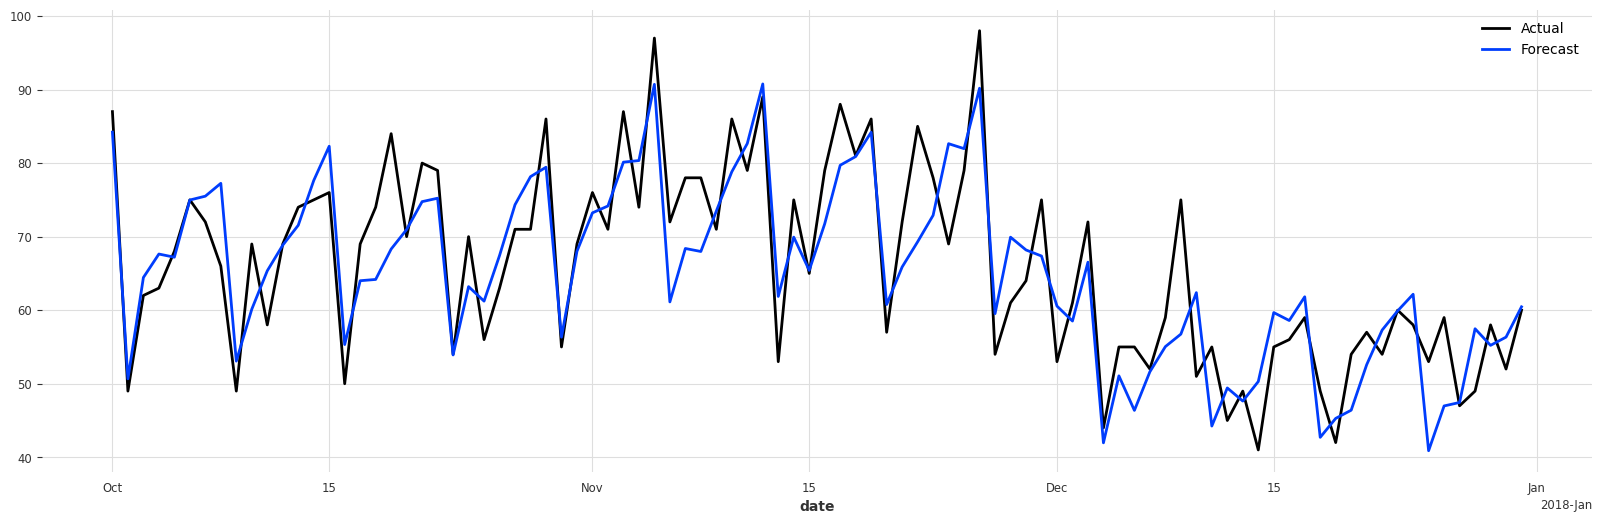

MAPE: 8.31%


In [37]:
plot_forecast(val, forecast)
calculate_mape(val, forecast)

## Exponential Smoothing

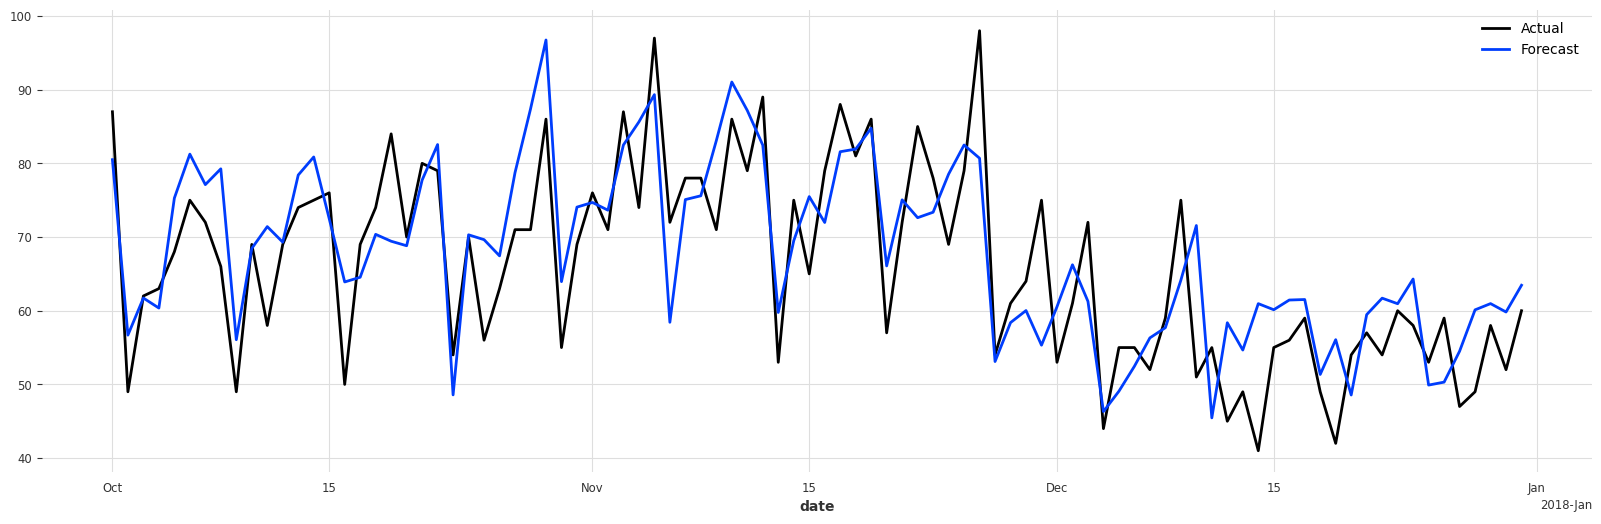

MAPE: 10.85%


In [38]:
es = ExponentialSmoothing(seasonal_periods=364)
es.fit(train)
forecast = es.predict(len(val))

plot_forecast(val, forecast)
calculate_mape(val, forecast)

## Prophet

In [ ]:
prophet = Prophet(country_holidays='US')
prophet.fit(train)

forecast = prophet.predict(len(val))

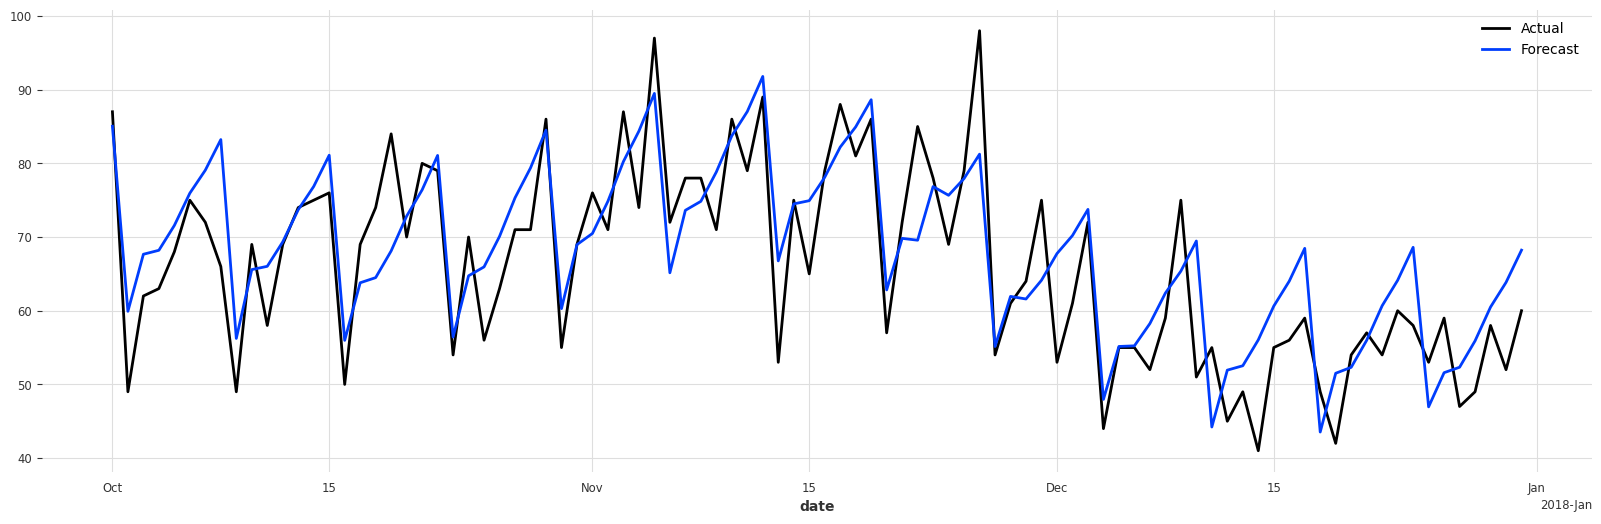

MAPE: 9.75%


In [40]:
plot_forecast(val, forecast)
calculate_mape(val, forecast)

# Backtesting


Backtesting in time series analysis is a technique used to evaluate a model’s predictive accuracy by simulating real-world forecasting. It involves training the model on historical data, then sequentially predicting future values over a validation period and comparing these predictions against actual observed data. This approach helps assess the model's performance and reliability before using it in production.

Let's do backtesting on Prophet and XGBoost models.

**Prophet**:

In [29]:
backtest_start = pd.Timestamp("2017-01-01")

hfc_params = {
    "series": series,
    "start": backtest_start,
    "forecast_horizon": 30,
    "verbose": False,
    "retrain": True,
    "last_points_only": True,
    "enable_optimization": True
}

In [43]:
actual_before, actual_after = series.split_before(backtest_start)

In [ ]:
historical_fcast = prophet.historical_forecasts(**hfc_params)

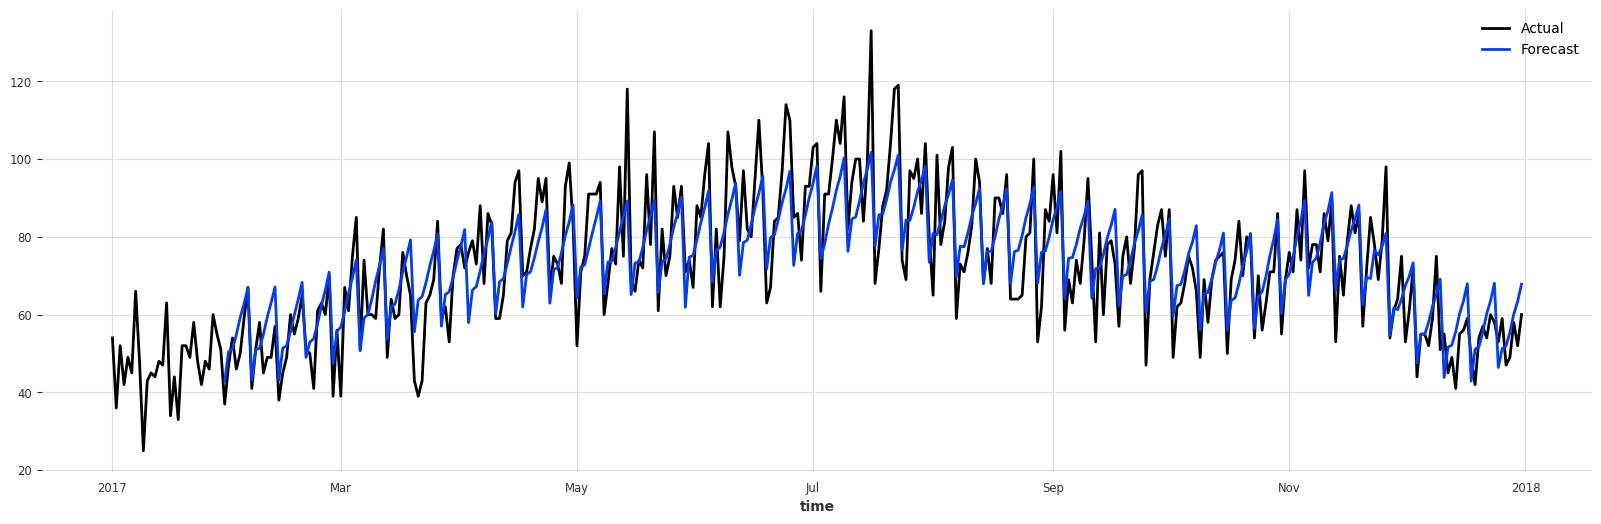

MAPE: 10.40%


In [45]:
plot_forecast(actual_after, historical_fcast)
calculate_mape(actual_after, historical_fcast)

XGBoost:

In [49]:
cov_before, cov_after = covariates.split_before(backtest_start)

In [ ]:
historical_fcast_xgb = xgb.historical_forecasts(**hfc_params, past_covariates = cov_after)

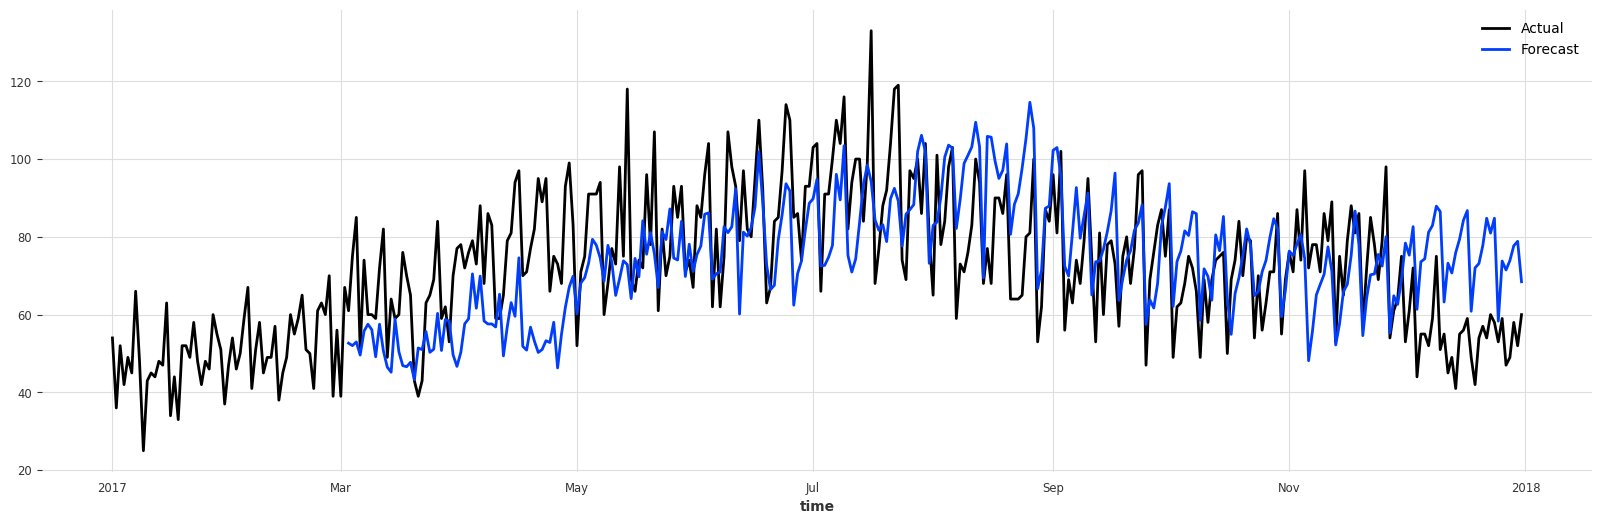

MAPE: 18.82%


In [51]:
plot_forecast(actual_after, historical_fcast_xgb)
calculate_mape(actual_after, historical_fcast_xgb)

Prophet model is showing better results on backtesting than XGBoost.

## XGB on full data:

Let's build an XGBoost regressor on the full data as opposed to an item-store data combination:

In [22]:
# Add date features
df_enriched = enrich_with_date_features(df)
df_enriched = df_enriched.sort_index()

In [23]:
# Split into train, test, input and target
train_df, val_df = df_enriched[:split_date].copy(), df_enriched[split_date:].copy()

input_cols = df_enriched.columns.drop('sales')
target_col = 'sales'

X_train = train_df[input_cols]
y_train = train_df[target_col]
X_val = val_df[input_cols]
y_val = val_df[target_col]

In [24]:
# Fit the model
xgbr = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.1,
    random_state=42
)
xgbr.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [25]:
# Predict and store predictions
xgbr_forecast = xgbr.predict(X_val)
val_df['sales_predicted'] = xgbr_forecast

In [26]:
# Function to plot forecast for selected item-store combination
def plot(df, item, store):
  plt.figure(figsize=(20,6))

  df_item_store = df[(df.item==item) & (df.store==store)]
  df_item_store['sales'].plot(label='Actual')
  df_item_store['sales_predicted'].plot(label='Forecast')

  plt.legend()
  plt.show()

  mape = mean_absolute_percentage_error(df_item_store['sales'], df_item_store['sales_predicted']) * 100
  print("Mape: {:.2f}%".format(mape))

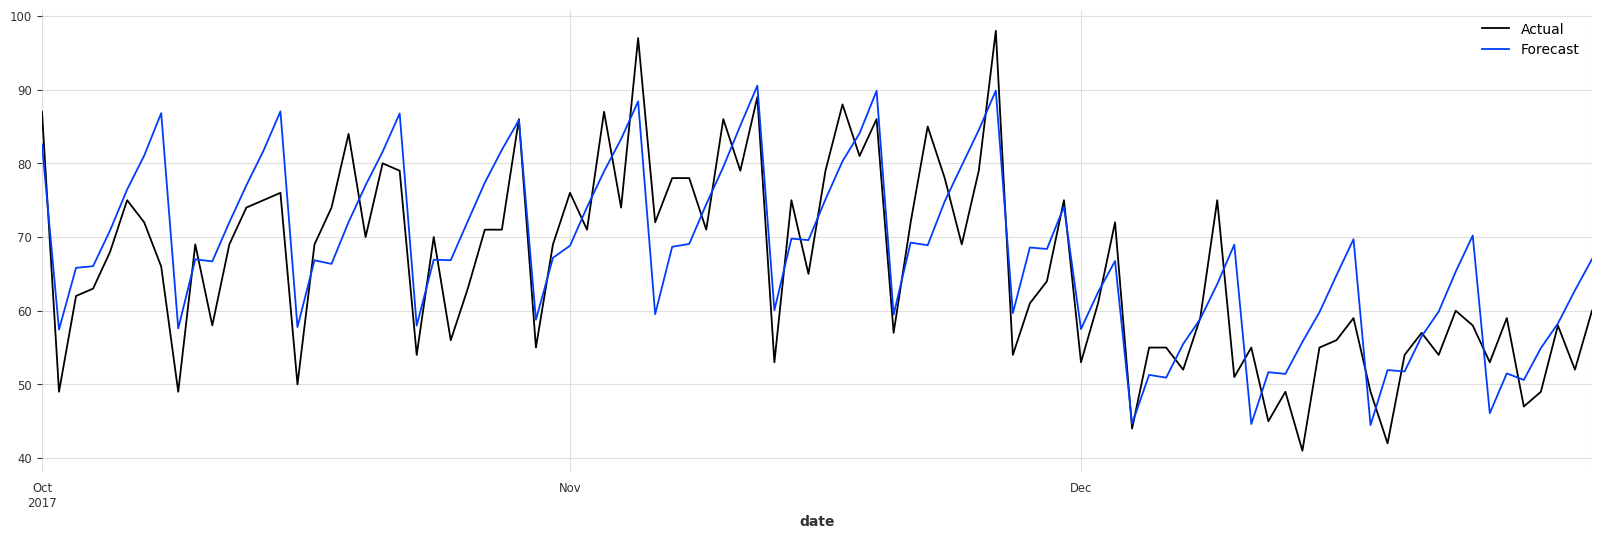

Mape: 9.90%


In [27]:
plot(val_df, 12, 1)

## Backtesting

In [32]:
backtest_end = pd.Timestamp("2017-12-31")

# Initialize an expanding window
train_data = df_enriched[:backtest_start]

# Adding a column for predictions
df_enriched['sales_predicted'] = np.nan

mape_scores = []
all_predictions = []

# Iterate over each month in 2017 for backtesting
for period_start in pd.date_range(backtest_start, backtest_end, freq='MS'):
    period_end = period_start + pd.DateOffset(months=1) - pd.DateOffset(days=1)

    # Select the validation data for the current period
    val_data = df_enriched[period_start:period_end]

    # Prepare training and validation sets
    X_train, y_train = train_data[input_cols], train_data[target_col]
    X_val, y_val = val_data[input_cols], val_data[target_col]

    # Train the model
    xgbr.fit(X_train, y_train)

    # Forecast sales for the validation period
    y_pred = xgbr.predict(X_val)

    # Store predictions
    df_enriched.loc[period_start:period_end, 'sales_predicted'] = y_pred

    # Calculate MAPE and store it
    mape = mean_absolute_percentage_error(y_val, y_pred) * 100
    mape_scores.append(mape)
    print(f"MAPE for period {period_start.strftime('%Y-%m')}: {mape:.2f}")

    # Expand the training data to include validation period
    train_data = pd.concat([train_data, val_data])

# Calculate average MAPE for the backtest period
average_mape = np.mean(mape_scores)
print(f"Average MAPE over 2017: {average_mape:.2f}")

MAPE for period 2017-01: 14.99
MAPE for period 2017-02: 14.06
MAPE for period 2017-03: 13.06
MAPE for period 2017-04: 11.91
MAPE for period 2017-05: 11.47
MAPE for period 2017-06: 10.82
MAPE for period 2017-07: 10.76
MAPE for period 2017-08: 11.90
MAPE for period 2017-09: 11.83
MAPE for period 2017-10: 13.00
MAPE for period 2017-11: 11.83
MAPE for period 2017-12: 15.37
Average MAPE over 2017: 12.58


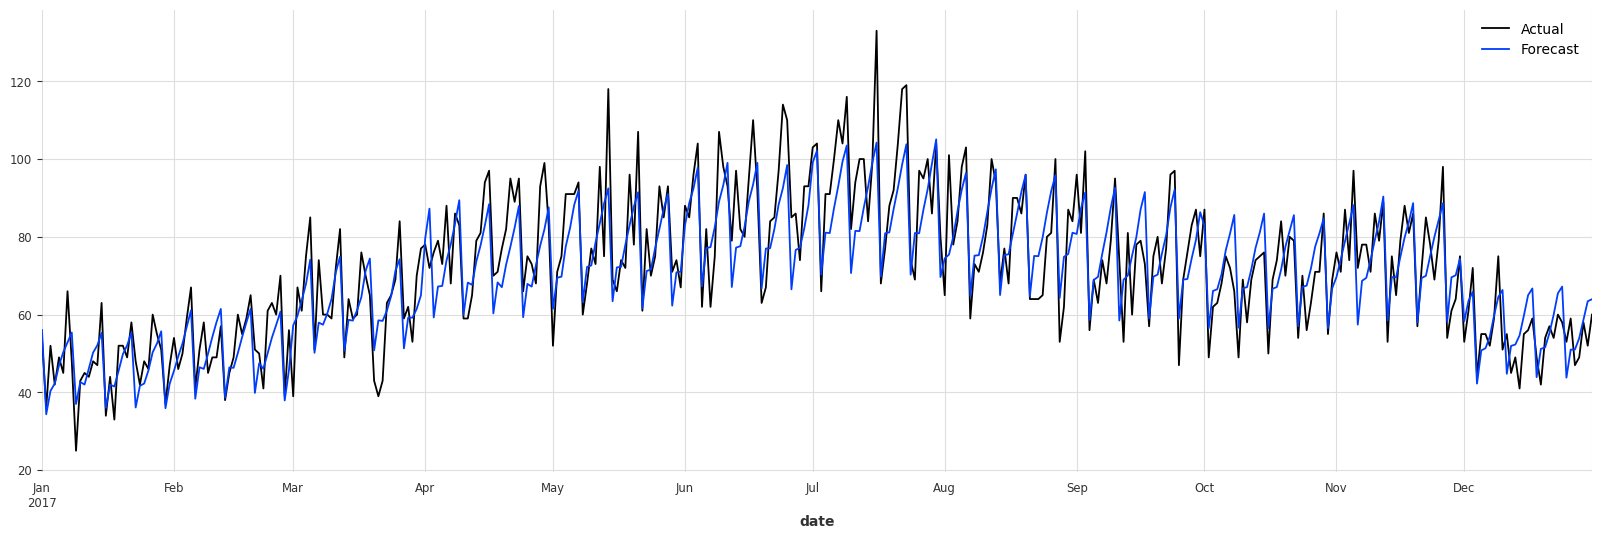

Mape: 9.91%


In [35]:
plot(df_enriched[backtest_start:backtest_end], 12, 1)